<a href="https://colab.research.google.com/github/CodeHana/Facial-Expression-Recognition/blob/main/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
reset -fs

In [84]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('white')

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
PROJ_PATH =  ("/content/drive/My Drive/fae_project/")
FAE_ZIPFILE = "face_emotion.zip"

DATA_FILENAME = "fae_dataset.csv"
DATA_DIR = PROJ_PATH + "emotion_data"
FAE_DATASET = PROJ_PATH + DATA_FILENAME

TRAIN_DIR = DATA_DIR+'/train'
VAL_DIR = DATA_DIR+'/validation'
TEST_DIR = DATA_DIR+'/test'
img_size = 48

In [87]:
# upload the file : if the file is not exit in google drive, ask the user to upload the emotion file
from google.colab import files

def upload_file_toDrive():
  print("file not exits in the google drive, please upload face_emotion.zip")
  uploaded = files.upload()

  for in_file in uploaded.keys():
    print('upload file "{fname}" with length {length} bytes'.format
          (fname=in_file , length = len(uploaded[in_file])))

In [76]:
# unzip file
from zipfile import ZipFile
def extract_zip(INPUT_FILE):
  
  print("extracting zip files...") 
  with ZipFile(INPUT_FILE, 'r') as zip:
    zip.extractall(DATA_DIR)
    print("Done")

In [88]:
# 1. read google drive zip file, 2. extract images in zip file, 3. store in emotion_data folder

# check if emotion_data folder exitst
# If folder doesn't exist, then create it.

CHECK_FOLDER = os.path.isdir(DATA_DIR)

if not CHECK_FOLDER:
    os.makedirs(DATA_DIR)
    print("created folder : ", DATA_DIR)
else:
    print(DATA_DIR, "folder already exists.")


## check if the images extracted already, if yes, print completed; else extract the images from zip
if  os.path.isdir(TRAIN_DIR) and os.path.isdir(TEST_DIR):
  print("{FAE_ZIPFILE} extracted complete!")
else:
  try:
    INPUT_FILE = (PROJ_PATH+ FAE_ZIPFILE)
    if not os.path.exists(INPUT_FILE):
      upload_file_toDrive()
    
    extract_zip(INPUT_FILE)
  except IOError:
    print('file not found')

/content/drive/My Drive/fae_project/emotion_data folder already exists.
{FAE_ZIPFILE} extracted complete!


#### **Make sure there are train/ validation/ test before running followings**
###- **Read all the images and convert to array**
##### - Create validation folder and move PublicTest*.jpg under test folder to validation according to different emotion labels


In [99]:
#where: train/ validation/ test
#labels: 'angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'
#path: /content/drive/My Drive/fae_project/emotion_data/where+label
# -- verify if there's any corrupt image if corrupted, move image to corrupted_data folder
from PIL import Image
import cv2
import shutil

dataset = {"where":[], "labels":[], "image_path":[], "pixels":[]}
corrupted_data_path = (PROJ_PATH+"/corrupted_data")

for where in os.listdir(DATA_DIR): 
  for label in os.listdir(DATA_DIR+"/"+where):
    for image in os.listdir(DATA_DIR + "/" + where + "/" + label):
        img_path = DATA_DIR + "/" + where + "/" + label + "/" + image
        try:
          # verify if there's any corrupt image
          if image.split(".")[1] =="jpg":
            # img = Image.open(img_path)
            # img.verify()
            img_array = cv2.imread(img_path)
            dataset["where"].append(where)
            dataset["labels"].append(label)
            dataset["image_path"].append(img_path)
            dataset["pixels"].append(img_array)   
        except (IOError, SyntaxError) as e: 
          print("damaged file:", image)
          shutil.move(img_path, corrupted_data_path)

In [101]:
dataset = pd.DataFrame.from_dict(dataset)

where
train         28709
test           3603
validation     3575
dtype: int64

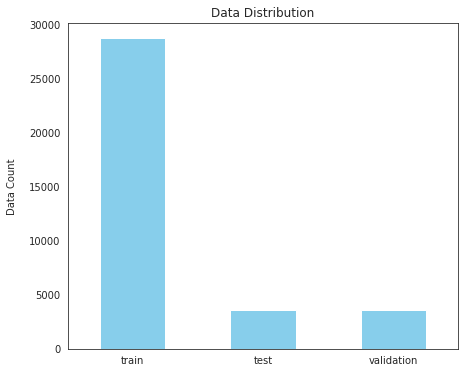

In [148]:
dataset.value_counts("where").plot(kind='bar', figsize=(7, 6),color = "skyblue")

plt.title("Data Distribution")
plt.xlabel(None)
plt.ylabel("Data Count", labelpad=12)
plt.xticks(rotation=0);
dataset.value_counts("where")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if sys.path[0] == '':


lables,where,happy,neutral,sad,fear,angry,surprise,disgust,total
0,test,879,626,594,542,491,416,55,3603
1,train,7215,4965,4830,4097,3995,3171,436,28709
2,validation,895,607,653,482,467,415,56,3575


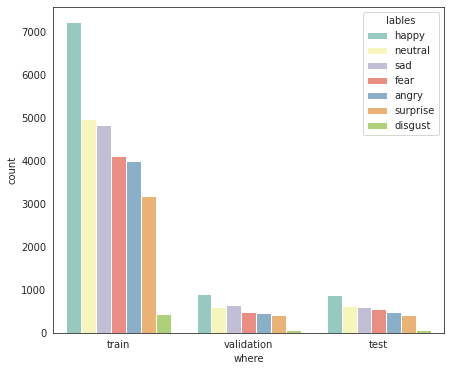

In [149]:
data_cnt_df = pd.DataFrame(dataset.value_counts(["where","labels"])).reset_index()
data_cnt_df.columns = ["where", "lables", "count"]

#plot1
fig, ax = plt.subplots(figsize=(7, 6))
sns.barplot(x = 'where', y = 'count', hue = 'lables', data = data_cnt_df, palette="Set3")


emotion_labels = ['happy', 'neutral','sad', 'fear', 'angry', 'surprise','disgust']

pvd = pd.pivot_table(data_cnt_df, values ="count", index=["where"], columns=["lables"], aggfunc=np.sum)[emotion_labels].copy().reset_index()
pvd["total"] = pvd.sum(axis = 1)


# #Plot 2
# fig, axes = plt.subplots(1,3, figsize=(15,5) )

# for idx , wh in enumerate(["train", "validation", "test"]):
#   counts_dict = dataset[dataset["where"]==wh]['labels'].value_counts().to_dict()

#   plt.subplot(1, 3, idx+1)
#   plt.bar(counts_dict.keys(), counts_dict.values(), tick_label=emotion_labels)
#   plt.xticks(rotation=90)
#   plt.title(wh)

pvd

In [150]:
dataset.iloc[5000]["image_path"]

'/content/drive/My Drive/fae_project/emotion_data/test/happy/PrivateTest_4628769.jpg'

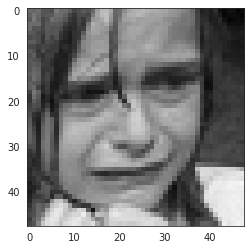

In [151]:
img_array = dataset.iloc[1000]["pixels"]
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))


**Resize the image for better resolution**

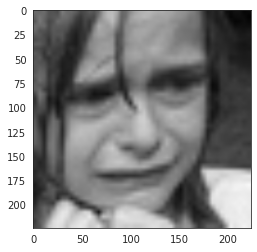

In [152]:
new_img_size = 224
img_array = dataset.iloc[1000]["pixels"]
new_array = cv2.resize(img_array, (new_img_size, new_img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))


In [153]:
dataset["224_pixels"] = dataset["pixels"].apply(lambda row: cv2.resize(row, (new_img_size, new_img_size)))

In [176]:
dataset.head(5)

,where,labels,image_path,pixels,224_pixels
0,validation,angry,/content/drive/My Drive/fae_project/emotion_da...,"[[[158, 158, 158], [162, 162, 162], [160, 160,...","[[[158, 158, 158], [158, 158, 158], [158, 158,..."
1,validation,angry,/content/drive/My Drive/fae_project/emotion_da...,"[[[103, 103, 103], [149, 149, 149], [175, 175,...","[[[103, 103, 103], [103, 103, 103], [105, 105,..."
2,validation,angry,/content/drive/My Drive/fae_project/emotion_da...,"[[[149, 149, 149], [149, 149, 149], [151, 151,...","[[[149, 149, 149], [149, 149, 149], [149, 149,..."
3,validation,angry,/content/drive/My Drive/fae_project/emotion_da...,"[[[19, 19, 19], [52, 52, 52], [42, 42, 42], [4...","[[[19, 19, 19], [19, 19, 19], [20, 20, 20], [2..."
4,validation,angry,/content/drive/My Drive/fae_project/emotion_da...,"[[[55, 55, 55], [48, 48, 48], [45, 45, 45], [4...","[[[55, 55, 55], [55, 55, 55], [55, 55, 55], [5..."


In [177]:
#save image data to csv file
dataset.to_csv("/content/drive/My Drive/fae_project/fae_dataset.csv")

In [178]:
if os.path.isfile("/content/drive/My Drive/fae_project/fae_dataset.csv"):
  try:
    dataset
  except NameError:
      dataset = pd.read_csv("/content/drive/My Drive/fae_project/fae_dataset.csv", index_col=0)


### **show images randomly**

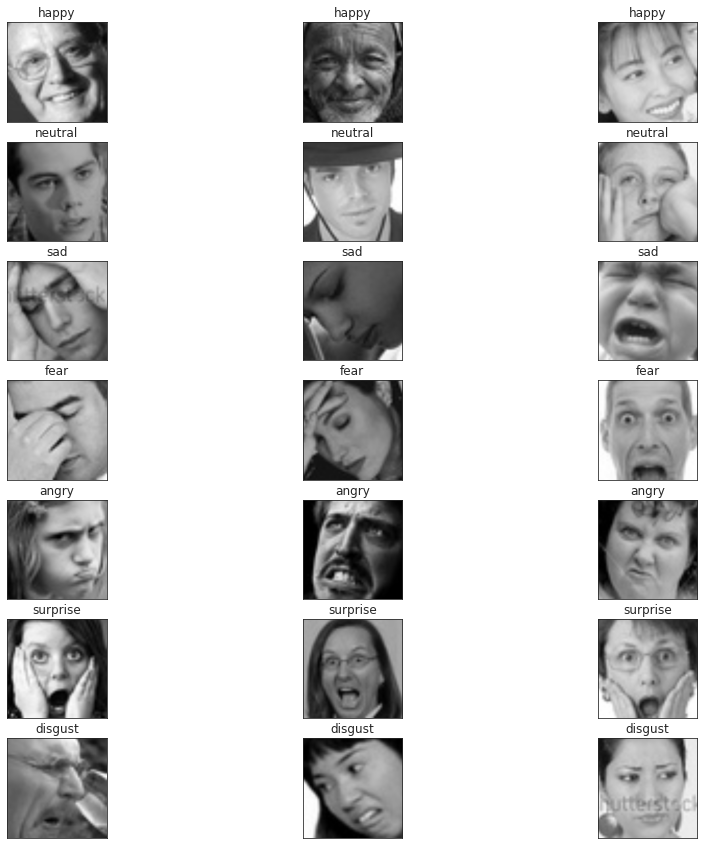

In [181]:
import random

fignum = 3
fig, axes = plt.subplots(len(emotion_labels),fignum, figsize =(fignum*5,fignum*5))
#fig.subplots_adjust(hspace =.1, wspace=.1)
axes = axes.ravel()

for label in emotion_labels:
  row_num = (emotion_labels.index(label))

  for clm_num in range(fignum):

    img_array = dataset[(dataset["labels"]== label) & (dataset["where"]=="train")]["224_pixels"].iloc[random.randrange(0,200,2)]
    plt_idx = row_num * fignum + clm_num
    
    axes[plt_idx].imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    axes[plt_idx].set_title(label)
    axes[plt_idx].set_xticklabels([])
    axes[plt_idx].set_yticklabels([])

